# Training with PyTorch

## Dataset and DataLoader

These classes encapsulate process of pulling data from storageand exposing it to training loop in batches.

`Dataset` reponsible for accessing, processing single instances of data.

`DataLoader` pulls data instances from `Dataset`, collects them in batches, returns them for consumption by training loop.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5))]
)

# Create datasets for training/validation, download if needed
training_set = torchvision.datasets.FashionMNIST(
    "./data", train=True, transform=transform, download=True
)
validation_set = torchvision.datasets.FashionMNIST(
    "./data", train=False, transform=transform, download=True
)

# Create dataloaders for datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(
    training_set, batch_size=4, shuffle=True, num_workers=2
)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=4, shuffle=False, num_workers=2
)

# Class labels
classes = (
    "T-shirt/top",
    "Trousers",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot",
)

# Report split sizes
print(f"Training set has {len(training_set)} instances")
print(f"Validation set has {len(validation_set)} instances")


Training set has 60000 instances
Validation set has 10000 instances


Coat  Coat  Shirt  Trousers


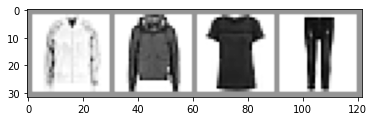

In [3]:
# Visualise data as sanity check

import matplotlib.pyplot as plt
import numpy as np

def mpl_imshow(img, one_channel=False):

    if one_channel:
        img = img.mean(dim=0)  # un-normalise

    npimg = img.numpy()

    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
imgs, labels = dataiter.next()

# Create grid from imgs and show them
img_grid = torchvision.utils.make_grid(imgs)
mpl_imshow(img_grid, one_channel=True)
print("  ".join(classes[labels[j]] for j in range(4)))

## The Model

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

## Loss Function

Using cross-entropy loss. For demo, will create batches of dummy output and label values, run them through loss func, examine result.

In [5]:
loss_fn = torch.nn.CrossEntropyLoss()

# Loss functions expect data in batches so creating batches of 4

dummy_outputs = torch.rand(4, 10)  # represents model's confidence in each class for given input
dummy_labels = torch.tensor([1, 5, 3, 7])  # represents correct class among 10 being tested

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print("Total loss for this batch:", loss.item())

tensor([[0.0050, 0.7989, 0.5650, 0.0950, 0.4083, 0.3137, 0.6809, 0.4107, 0.3736,
         0.9715],
        [0.1810, 0.6866, 0.2137, 0.2334, 0.2797, 0.6214, 0.6123, 0.5921, 0.8339,
         0.4829],
        [0.0661, 0.3882, 0.4717, 0.2877, 0.9255, 0.7022, 0.8812, 0.8307, 0.0334,
         0.0193],
        [0.9364, 0.8009, 0.5464, 0.7109, 0.1974, 0.5476, 0.8754, 0.8430, 0.3088,
         0.3213]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.2042508125305176


## Optimiser

Can be instructive to try some variations:
* Learning rate
* Momentum
* Different optimation algorithms, e.g. averaged SGD, Adagrad, Adam

In [9]:
# Optimisers specified in the torch.optim package
optimiser = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## The Training Loop

Below function performs one training epoch, enumerating data from DataLoader, and on each iteration:
* Gets batch of training data from DataLoader
* Zeroes optimiser gradients
* Performs inference; gets predictions from model for input batch
* Calculates loss and backward gradients over learning weights
* Tells optimiser to perform one learning step; adjust weights based on observed gradients for this batch based on chosen algorithm

Every 1000 batches:
* Reports on loss
* Reports average per-batch loss foor last 1000 batches for comparison with validation run

In [10]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here enumerate() instead of iter() so can track batch index and do intra-batch reporting
    for i, data in enumerate(training_loader):
        # Every datum is input & label pair
        inputs, labels = data

        # Zero gradients every batch!
        optimiser.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute loss and gradients wrt weights
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust weights
        optimiser.step()

        # Gather data and report
        running_loss += loss.item()

        if i % 1000 == 999:
            last_loss = running_loss / 1000  # averaged loss per batch
            print(f"Batch {i+1} loss: {last_loss}")
            tb_x = epoch_index * len(training_loader) + i+1
            tb_writer.add_scalar("Loss/train", last_loss, tb_x)
            running_loss = 0.

    return last_loss

### Per-Epoch Activity

Things to do once per epoch:
* Perform validation by checking and reporting relative loss on validation set
* Save copy of model

In [12]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f"runs/fashion_trainer_{timestamp}")

epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000

for epoch in range(EPOCHS):
    print(f"EPOCH {epoch_number+1}:")

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # Don't need gradients on for reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i+1)
    print(f"LOSS train {avg_loss} valid {avg_vloss}")

    # Log running loss averaged per batch for both training and validation
    writer.add_scalars("Training vs. Validation Loss",
                      {"Training": avg_loss, "Validation": avg_vloss},
                      epoch_number + 1)

    writer.flush()

    # Track best performance, and save model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f"model_{timestamp}_{epoch_number}"
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
Batch 1000 loss: 0.44278844503092113
Batch 2000 loss: 0.42222686467925086
Batch 3000 loss: 0.43416991249390413
Batch 4000 loss: 0.40771083073620684
Batch 5000 loss: 0.40874772053339986
Batch 6000 loss: 0.38942595323512796
Batch 7000 loss: 0.40811576587660237
Batch 8000 loss: 0.38728047940070975
Batch 9000 loss: 0.40065760730061445
Batch 10000 loss: 0.3853379342884291
Batch 11000 loss: 0.3796711550076143
Batch 12000 loss: 0.38953130280951154
Batch 13000 loss: 0.3723306601740769
Batch 14000 loss: 0.38023514188017
Batch 15000 loss: 0.3694767666700645
LOSS train 0.3694767666700645 valid 0.3824346959590912
EPOCH 1:
Batch 1000 loss: 0.34929781239078145
Batch 2000 loss: 0.35344019657117315
Batch 3000 loss: 0.362411810481688
Batch 4000 loss: 0.3392707388247945
Batch 5000 loss: 0.3354003721685731
Batch 6000 loss: 0.3411717004827733
Batch 7000 loss: 0.34406814431972454
Batch 8000 loss: 0.3344793949162413
Batch 9000 loss: 0.3717601099897875
Batch 10000 loss: 0.33473381502658595
Batch 110

KeyboardInterrupt: 